# Project 3, Runge-Kutta and 2-body orbital mechanics

**Devon DeJohn** | PHY 4611 | March 18, 2019

> This project explores one of the many physical systems in which the Euler integration method breaks down. In particular we plot the trajectory of Halley's comet, a highly elliptical comet with an orbital period of ~75 years. Elliptical orbits are of a type of system governed by "stiff" differential equations of motion, and as such do not play nicely with fixed-size timesteps.
>
> We start by demonstrating that even though Euler-Cromer conserves angular momentum, the scheme does not conserve energy and thus performs poorly for trajectories that are not nearly circular. We move on to the fourth-order Runge-Kutta method which performs admirably but remains too naïve for such a "stiff" system, and wastes computation time when orbits become highly elliptical. Finally we modify RK4 to be an adaptive algorithm, which adjusts its stepsize according to an energy-conservation-error threshold, and thus reduces the number of calculations necessary.


### Angular momentum iterated through Euler-Cromer

> Prove that for the Kepler problem the Euler-Cromer method conserves angular momentum exactly.

Let $v_{n+1} = v_n + a \,\tau$ and $r_{n+1} = r_n + v_{n+1} \,\tau$. Angular momentum is expressed as $L = r \times m\,v = m\,(r \times v)$, and in the two-body problem, $a_n = -\frac{\mu}{\|r_n\|^3} r_n$.
        
As above, the scalar $m$ can be factored to the outside of the cross product, and as such is omitted after the first line of the following for clarity. Other properties of the cross product are assumed, namely: $(a + b) \times c = (a \times c) + (b \times c)$ and $(a \times a) = 0$.

Then,

$$
\begin{align*}
    L_{n+1} &= m\,(r_{n+1} \times v_{n+1}) \\
    &= (r_n + v_{n+1} \tau) \times (v_n + a_n \,\tau) \\
    &= \big{(} r_n + (v_n + a_n \,\tau) \, \tau \big{)} \times (v_n + a_n \,\tau) \\
    &= \big{(} r_n \times (v_n + a_n \,\tau)\big{)} + \big{(}(v_n + a_n \,\tau)\,\tau \times (v_n + a_n \,\tau)\big{)} \\
    &= r_n \times (v_n + a_n\,\tau) \\
    &= (r_n \times v_n) + (r_n \times a_n\,\tau) \\
    &= (r_n \times v_n) -\frac{\tau \, \mu}{\|r_n\|^3} (r_n \times r_n) \\
    &= L_n
\end{align*}
$$

Thus stepwise angular momentum through Euler-Cromer is conserved exactly. 

Maximum error: 69.2044 %


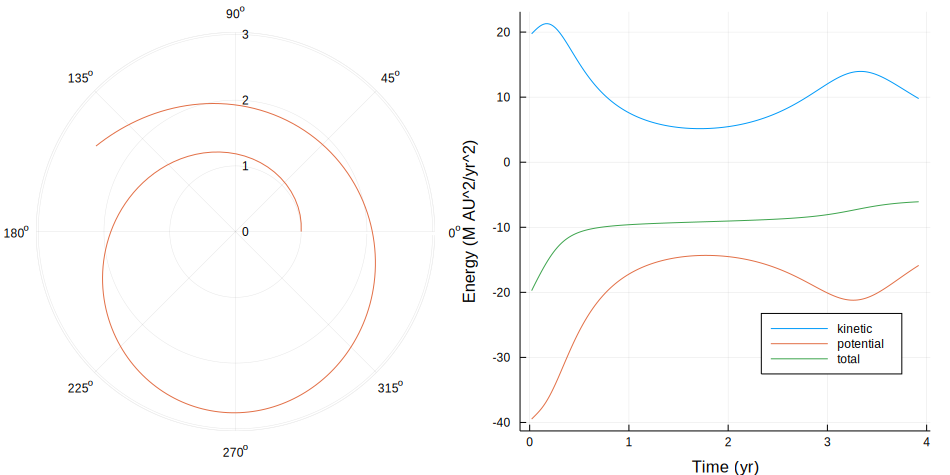

In [156]:
plot_orbit(get_orbit(State([1, 0], [0, 2*pi]), euler, 0.02))

Maximum error: 1.5849 %


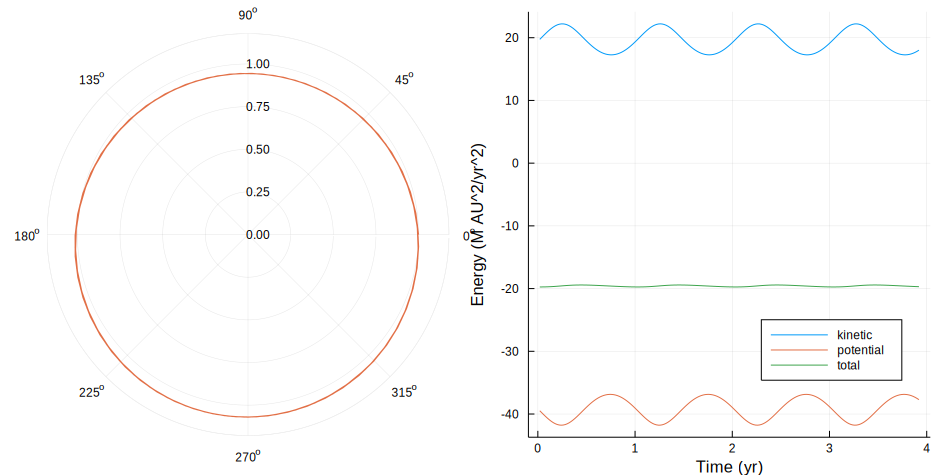

In [157]:
plot_orbit(get_orbit(State([1, 0], [0, 2*pi]), cromer, 0.02))

Maximum error: 79.7683 %


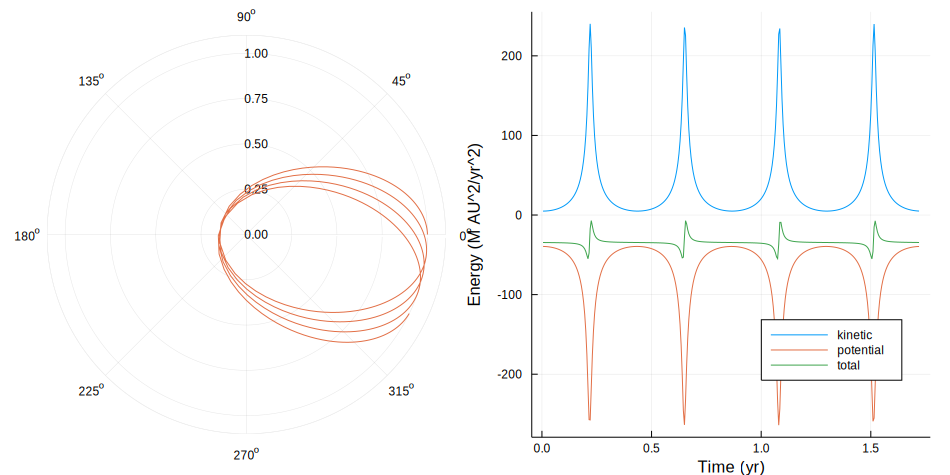

In [158]:
plot_orbit(get_orbit(State([1, 0], [0, pi]), cromer, 0.005))

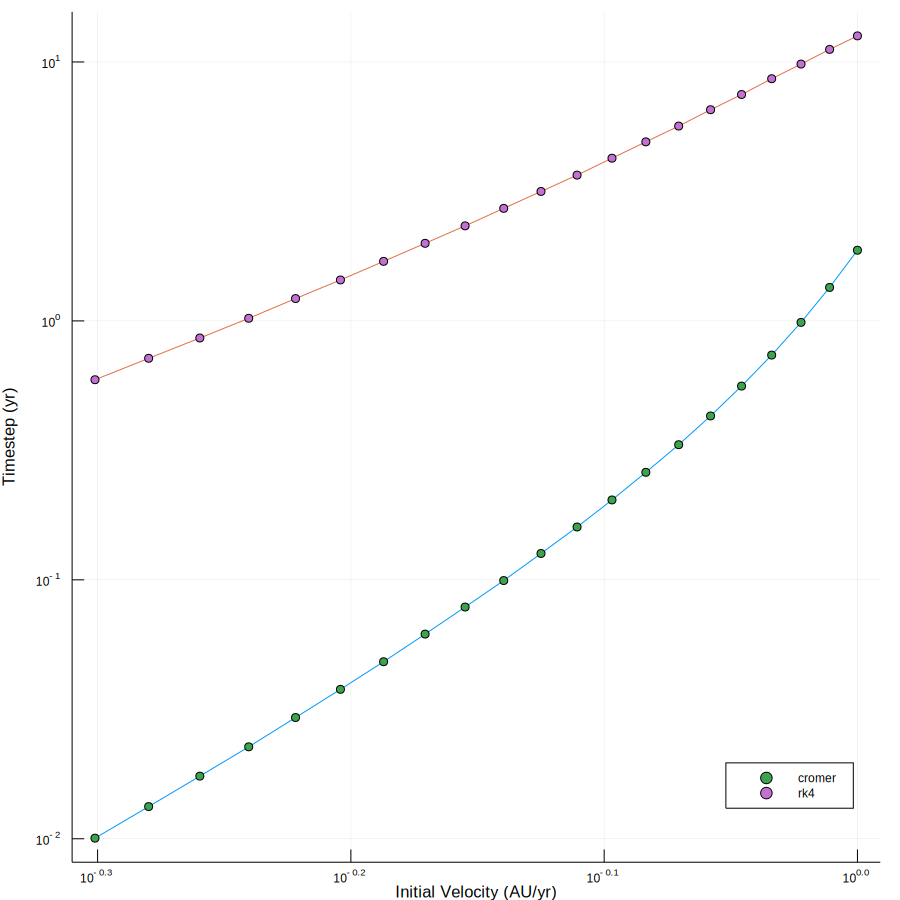

In [159]:
# Start with a timestep of pi, because why not?
cr_taus = get_best_tau(cromer, convert(Float64, pi))
rk_taus = get_best_tau(rk4, 20.)

plot_taus(cr_taus, rk_taus)

In [160]:
plot_orbit(get_orbit(State([r, 0], [0, v]), rk4, 0.005)) # Plot Halley's Comet over 4 orbits.

Maximum error: 0.0030 %


# Appendix A, code base

In [155]:
using Plots
using Printf
gr()

#——————————————————————————————————————————————————————————————————————————————————————————————————#
# Constants

# const μ = 1.3271244004193938e20 # JPL ephermerides, August 2018
# const AU = 1.495978707e11 # JPL ephermerides, August 2018
# const m_h = 2.2e14 # Halley's comet mass (wikipedia)

const μ = 4*pi^2

#——————————————————————————————————————————————————————————————————————————————————————————————————#
# Orbital state vector

struct State
    r::AbstractVector{Float64}
    v::AbstractVector{Float64}
end

# Define scalar multiplication and addition on state vectors.
Base.:*(k::Number, S::State) = State(k*S.r, k*S.v)
Base.:+(A::State, B::State) = State(A.r + B.r, A.v + B.v)

# Just a container for holding orbital data for plotting purposes.
struct Orbit
    ρ; θ; K; U; E; Ers; τ
end

struct Taus_Vs 
    v; τ
end

#——————————————————————————————————————————————————————————————————————————————————————————————————#
# Helper functions

function nrm(r)
    return sqrt(sum(r.^2))
end

function f(X::State)
    dr = X.v
    dv = -(μ/nrm(X.r)^3) * X.r
    return State(dr, dv)
end

function energy(X::State)
    k = 1/2*nrm(X.v)^2
    u = -μ/nrm(X.r)
    return (K=k, U=u, E=k+u)
end

function abs_error(exp, theo)
    return abs(100*(exp - theo)/theo)
end

#——————————————————————————————————————————————————————————————————————————————————————————————————#
# Integrators

function euler(X::State, τ::Float64)
    v = X.v -(τ*μ/nrm(X.r)^3) * X.r
    r = X.r + τ*X.v
    return State(r, v)
end

function cromer(X::State, τ::Float64)
    v = X.v -(τ*μ/nrm(X.r)^3) * X.r
    r = X.r + τ*v
    return State(r, v)
end

function rk(X::State, τ::Float64)
    return X + τ * f(X + τ/2 * f(X))
end

function rk4(X::State, τ::Float64)
    k1 = f(X)
    k2 = f(X + τ/2*k1)
    k3 = f(X + τ/2*k2)
    k4 = f(X + τ*k3)

    return X + τ/6 * (k1 + 2*k2 + 2*k3 + k4)
end

#——————————————————————————————————————————————————————————————————————————————————————————————————#
# Plotting

function get_orbit(s::State, method=rk4, τ=0.005)   
    # Initial total energy, against which we compare total energy through trajectory.
    E_i = energy(s).E
    
    r = nrm(s.r)
    v = nrm(s.v)
    
    # Find period of orbit.
    a = r*μ/(2*μ - r*v^2)
    T = 2*pi*sqrt(a^3/μ)

    # Divide period of orbit by tau to get evenly spaced steps; do 4 orbits.
    steps = convert(Int64, 4*div(T, τ))
    
    # Preallocate arrays for orbit data.
    ρ = Array{Float64}(undef, steps)
    θ = Array{Float64}(undef, steps)
    K = Array{Float64}(undef, steps)
    U = Array{Float64}(undef, steps)
    E = Array{Float64}(undef, steps)
    Ers = Array{Float64}(undef, steps)
    
    # Begin trajectory calcs.
    for i in 1:steps
        nrg = energy(s)
        err = abs_error(nrg.E, E_i)
        ρ[i], θ[i], K[i], U[i], E[i], Ers[i] = nrm(s.r), atan(s.r[2], s.r[1]), nrg.K, nrg.U, nrg.E, err   
        s = method(s, τ)
    end
    
    return Orbit(ρ, θ, K, U, E, Ers, τ)
end

function get_best_tau(method, τ)
    vels = []
    taus = []
    
    r = 35.
    
    for v in 0.5:0.025:1.0
        # Recall get_orbit with initial state if we get a bad trajectory (err > 1%).
        S_i = State([35.,0.], [0., v])
        s = S_i

        # Initial total energy, against which we compare total energy through trajectory.
        E_i = energy(s).E
        
        function propagate(s::State, τ)
            # Flag used to recall if bad trajectory is found.
            bad_traj = false
            
            # Find period of orbit.
            a = r*μ/(2*μ - r*v^2)
            T = 2*pi*sqrt(a^3/μ)
            
            # Divide period of orbit by tau to get evenly spaced steps; do 2 orbits.
            steps = 2*div(T, τ)
            
            # Begin trajectory calcs.
            for i in 1:steps
                err = abs_error(energy(s).E, E_i)

                # Short-circuit if we get a bad trajectory.
                if err > 1
                    bad_traj = true
                    break
                else
                    s = method(s, τ)
                end
            end

            if bad_traj
                # Start over with 99.5% of original tau if bad trajectory found.
                propagate(S_i, τ*0.995)
            else
                return τ
            end
        end
        
        # Push a good tau into the array.
        push!(taus, propagate(s, τ))
        push!(vels, v)
    end
    
    return Taus_Vs(vels, taus)
end

function plot_orbit(o::Orbit)
    hspace = [o.τ*i for i in 1:length(o.ρ)]
    
    max_err = maximum(o.Ers)
    @printf("Maximum error: %.4f %%\n", max_err)
    
    p1 = plot([0], [0], label=:"", proj=:polar)
    p2 = plot(hspace, o.K, label=:"kinetic", 
                yaxis=:"Energy (M AU^2/yr^2)", xaxis=:"Time (yr)",
                legend=:bottomright)

    plot!(p1, o.θ, o.ρ, label=:"")
    plot!(p2, hspace, o.U, label=:"potential")
    plot!(p2, hspace, o.E, label=:"total")
    plot(p1, p2, size=(950,475))
end

function plot_taus(T1::Taus_Vs, T2::Taus_Vs)
    hspace = [v for v in T1.v]
    p = scatter(size=(900,900),
            yaxis=(:log, "Timestep (yr)"),
            xaxis=(:log, "Initial Velocity (AU/yr)"),
            legend=:bottomright)
    plot!(p, hspace, T1.τ, label=:"")
    plot!(p, hspace, T2.τ, label=:"")
    scatter!(p, hspace, T1.τ, label=:"cromer")
    scatter!(p, hspace, T2.τ, label=:"rk4")
    plot(p)
end;